In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import plotting_tools as pt
%matplotlib inline

from matplotlib.patches import Ellipse
from scipy.stats import norm

# this is a module I created
from cluster_methods import *

from sklearn import decomposition
import skfuzzy as fuzz
from sklearn import preprocessing

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)

from scipy import linalg

from sklearn.mixture import GMM

import itertools

# Testing methods which will be applied to the blue cloud (not yet managed to select it) 
# instead looking at spirals + naive cut u-r colour < 1.8

# multiwavelength cat data + galaxy zoo
# 0: specobjID
# 1: stellar mass
# 2: error
# 3: SFR last 115 Myr
# 4: dustVal ISM
# 5: redshift
# 6: prob. elliptical
# 7: prob. spiral
# 8: u
# 9: g
# 10: r
# 11: i
# 12: z
# 13: petro r
# 14: theta
# 15 sdss.u
# 16 sdss.g 
# 17 sdss.r 
# 18 sdss.i 
# 19 sdss.z
# 20 sdss.petroMag_r
# 21 sdss.petroR50_r
# 22 ukidds.yPetroMag 
# 23 ukidds.hPetroMag
# 24 ukidds.kPetroMag 
# 25 wise.w1mpro
# 26 wise.w2mpro 
# 27 wise.w3mpro
# 28 wise.w4mpro
# 29 galex.nuv_mag
# 30 galex.fuv_mag  

In [2]:
# array
galaxies = np.load('/home/calum/Documents/Mphys_data/mgs_multiwavelength/photvespa_properties.npy')
galaxies.shape

(77871, 31)

data = []

#create dataset for clustering
for row in galaxies:
    #if (row[4] > 0.004 and row[4] < 0.08) :
        # absolute r-band petrosian magnitude
        x0 = float(row[13])-5*(np.log10(cosmo.luminosity_distance(row[5]).to(u.pc).value/10))
        # u-r colour
        x1 = row[8]-row[10]
        # redshift
        x2 = row[5]
        # morphology
        if row[6] > 0.8:
            # elliptical
            x3 = 1
        elif row[7] > 0.8:
            # spiral
            x3 = -1
        else:
            # should we ommit these?
            x3 = 0
        # ISM dust value
        x4 = row[4]
        # log(stellar mass)
        x5 = np.log(row[1])
        # surface brightness
        x6 = row[10]+2.5*np.log10(2*np.pi*row[14]*row[14])

        # append to data
        data.append([x0,x1,x2,x3,x4,x5,x6])

np.save('/home/calum/Documents/Mphys_data/vespa_data/tmp_photvespa_data.npy',data)

In [3]:
data = np.load('/home/calum/Documents/Mphys_data/vespa_data/tmp_photvespa_data.npy')

In [4]:
data.shape

(77871, 7)

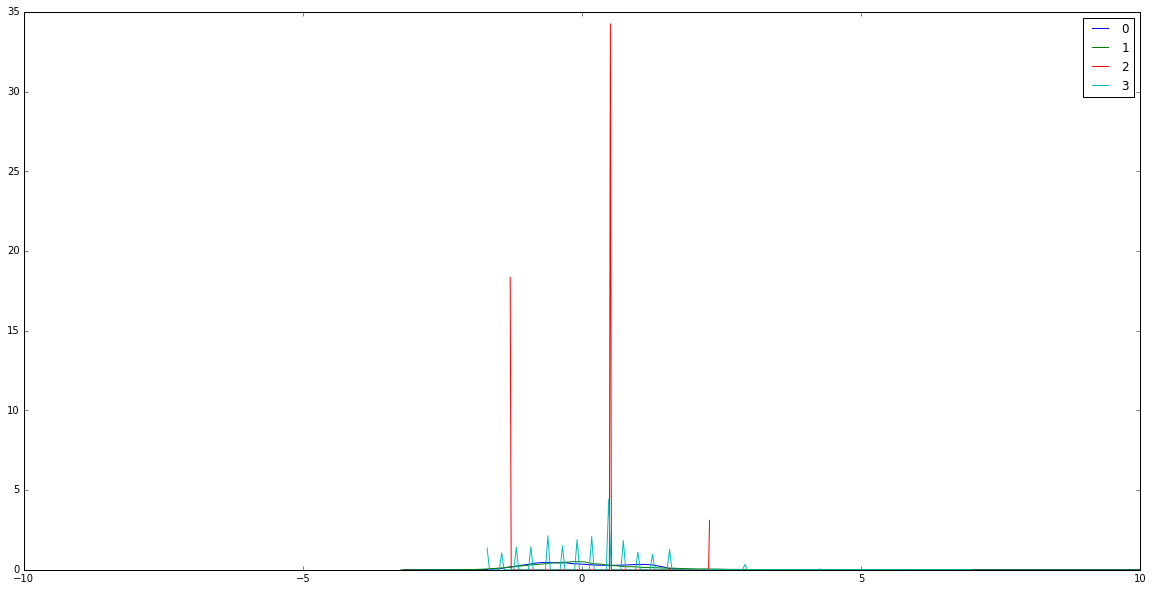

(26307, 3)


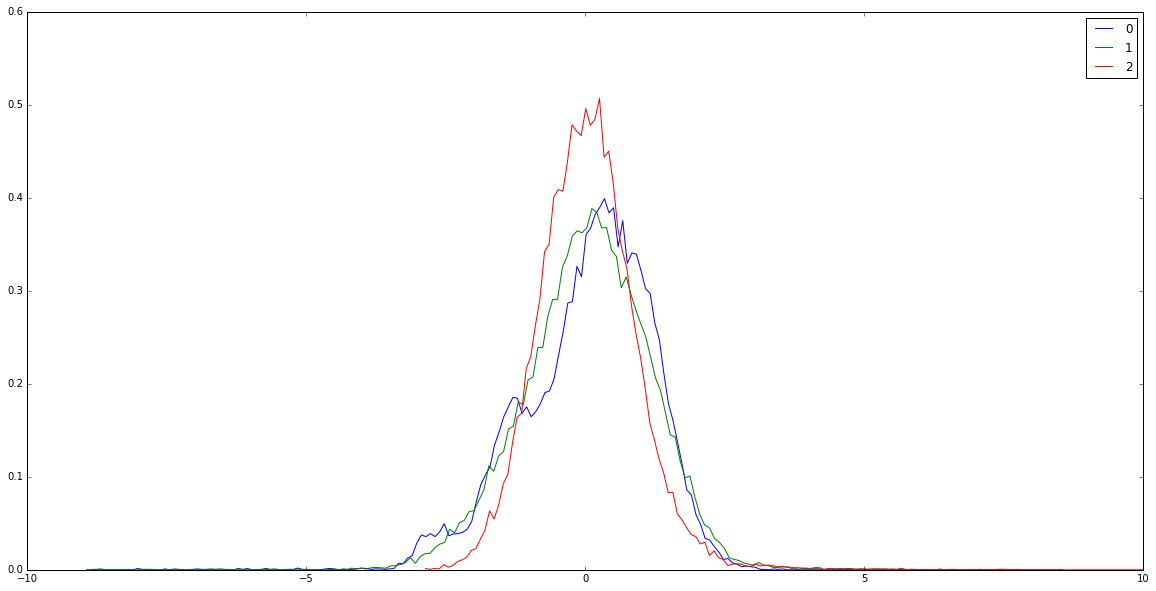

Conducting cluster analysis...
Number of iterations: 499 FPC 0.533179616733
cluster membership (26307,)
u shape (3, 26307)
Length of cluster 0 : 8470
Length of cluster 1 : 8723
Length of cluster 2 : 9114


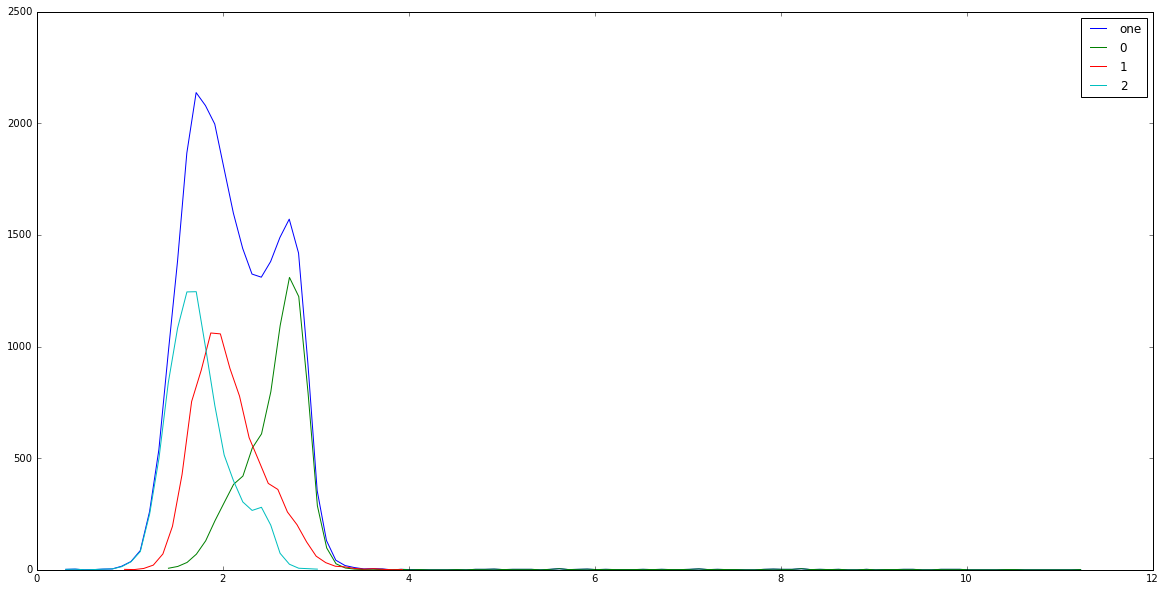

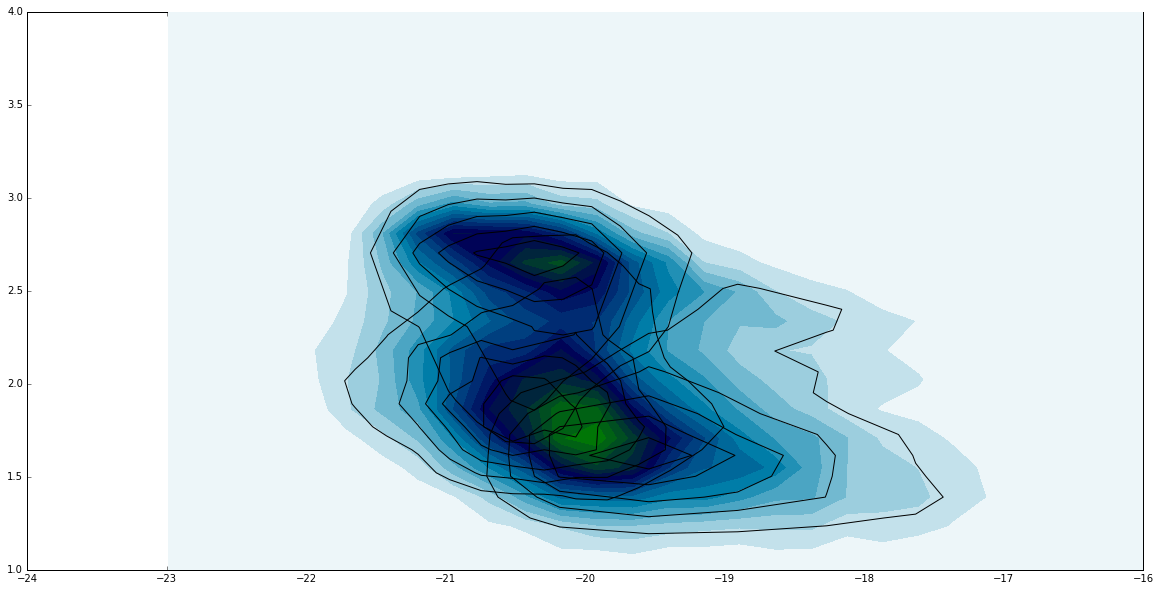

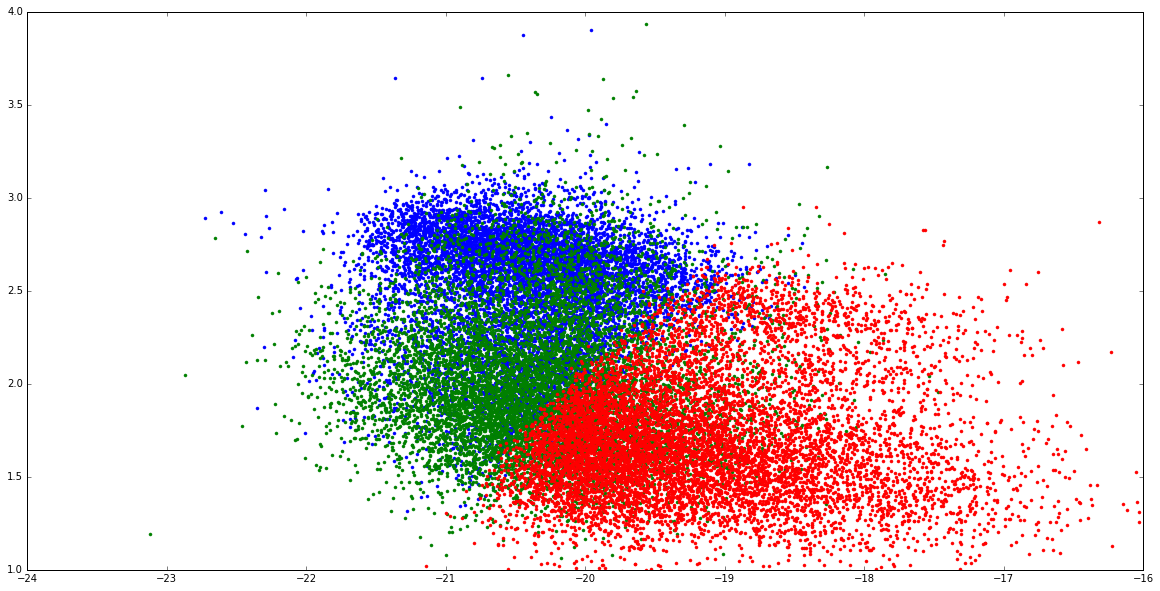

In [5]:
u0 = fclustering([[row[1],row[0],row[3],row[4]] for row in data if row[2]<0.08],3,n_pca='mle',error=1e-20)

In [6]:
all_data = np.array([[row[0],row[1]] for row in data if row[2]<0.08])
sall_data = preprocessing.scale(all_data,axis=0)

sall_data = np.array([[row[0],row[1]*100] for row in sall_data])
sall_data.shape

(26307, 2)

array([[  8.75400132e-02,   7.54680992e-01,   1.57778995e-01],
       [  3.41343545e-07,   6.28637748e-01,   3.71361911e-01],
       [  9.64891564e-03,   8.82334643e-01,   1.08016441e-01],
       ..., 
       [  1.87409445e-01,   6.60097029e-01,   1.52493526e-01],
       [  2.91069062e-01,   5.68305024e-01,   1.40625914e-01],
       [  1.44825898e-08,   2.96280574e-01,   7.03719411e-01]])

/home/calum/anaconda3/lib/python3.5/site-packages/matplotlib/transforms.py:1965: ComplexWarning: Casting complex values to real discards the imaginary part
  np.float_)


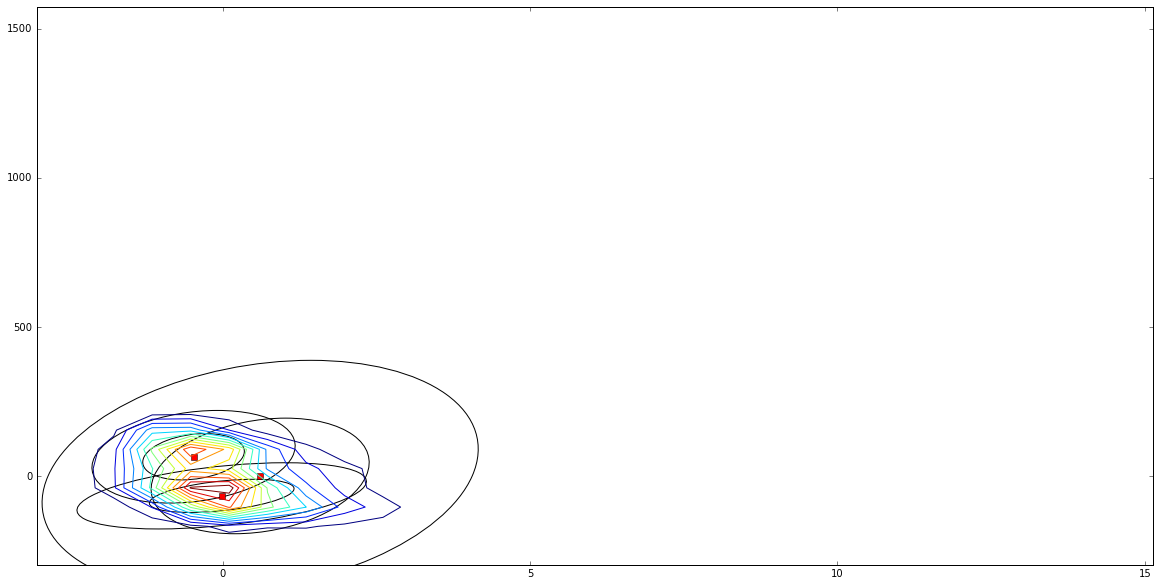

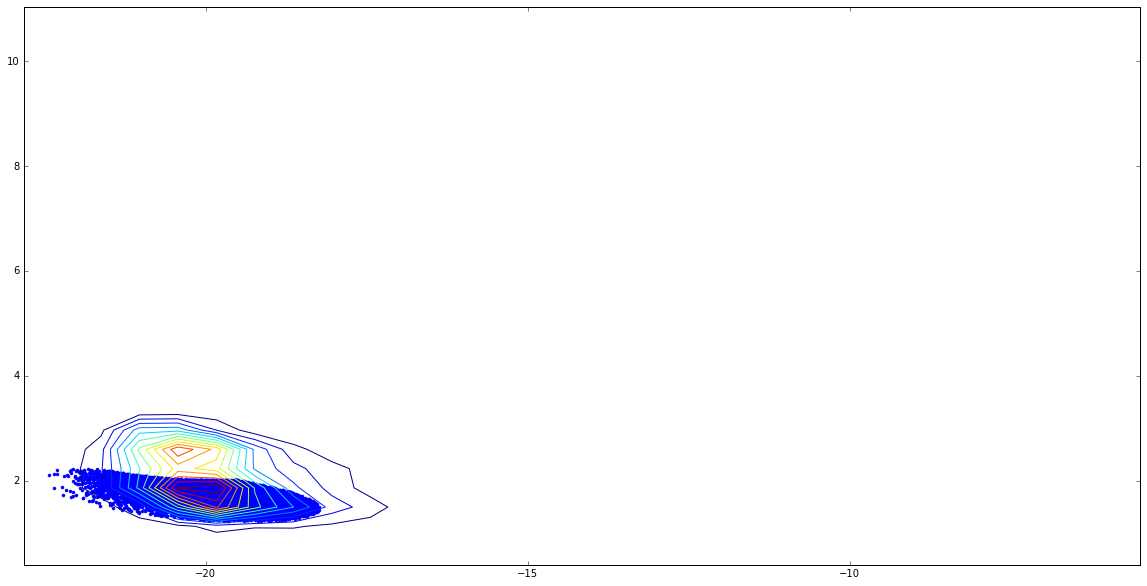

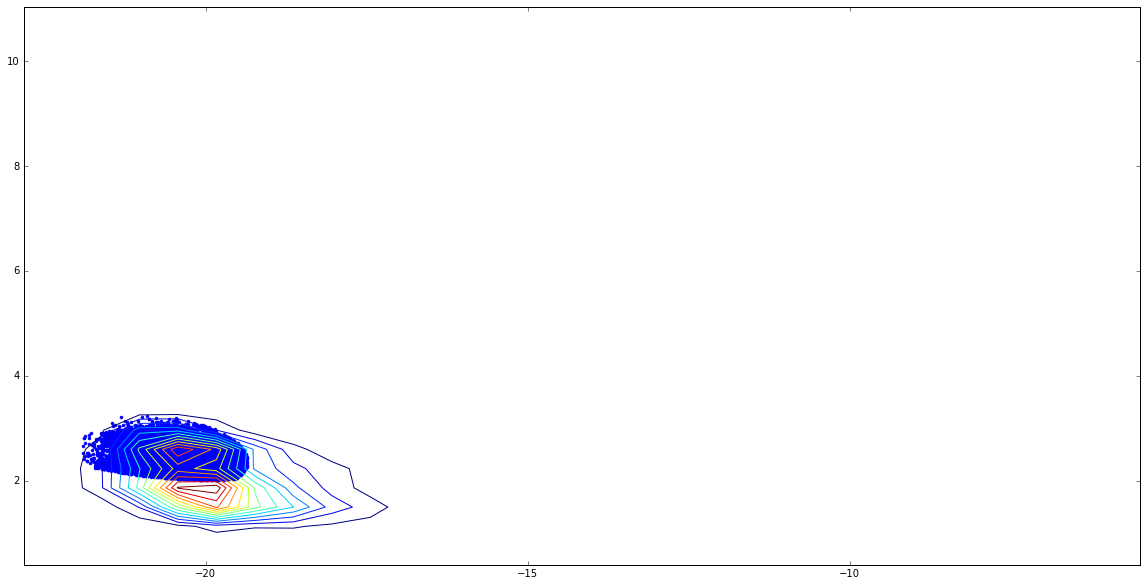

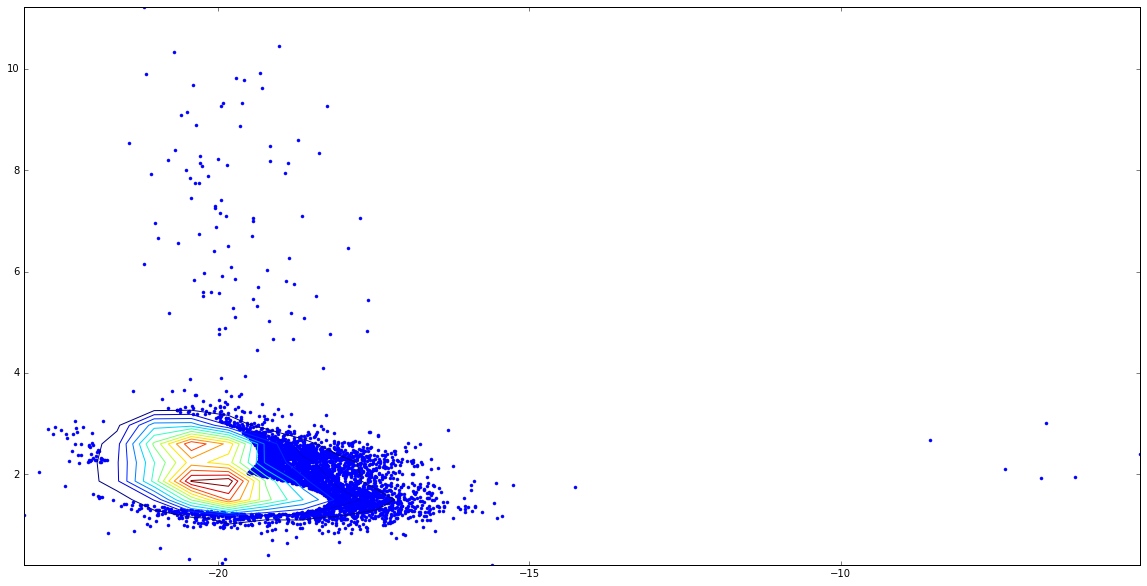

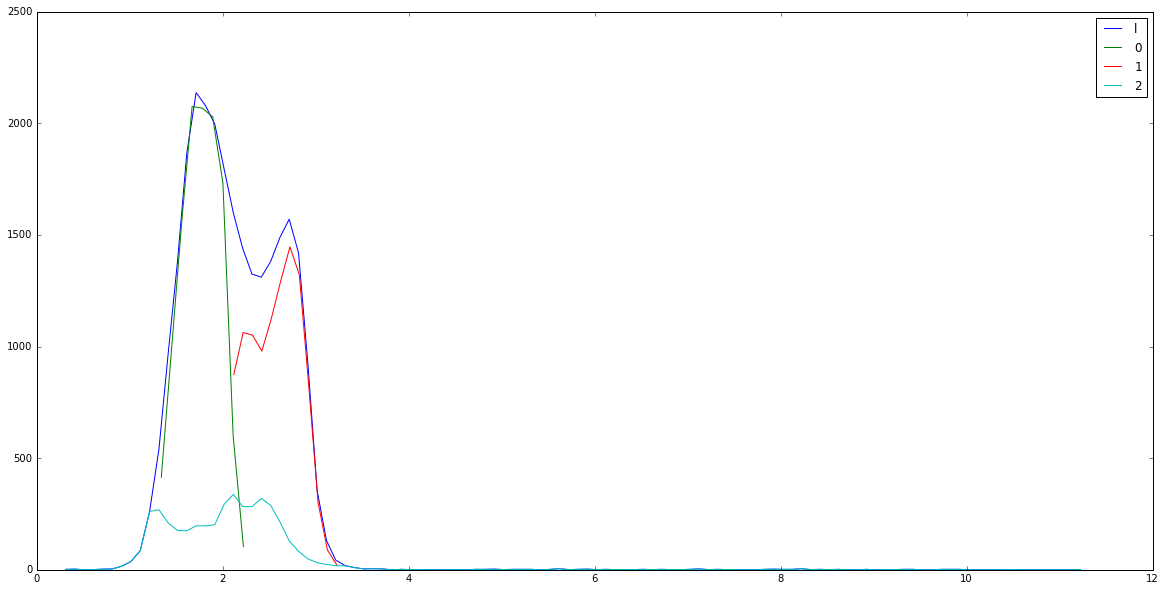

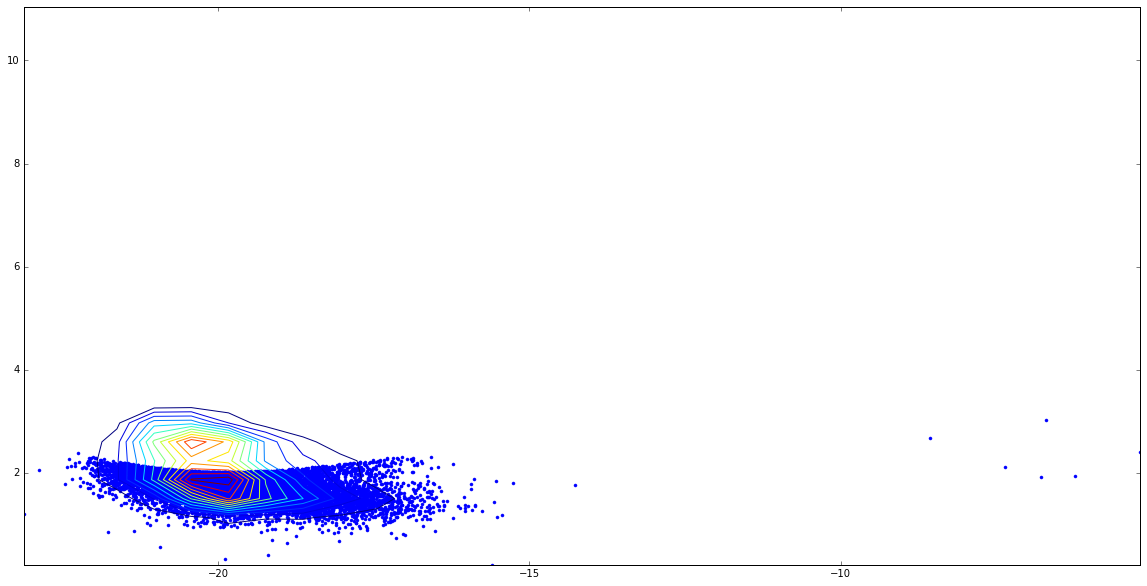

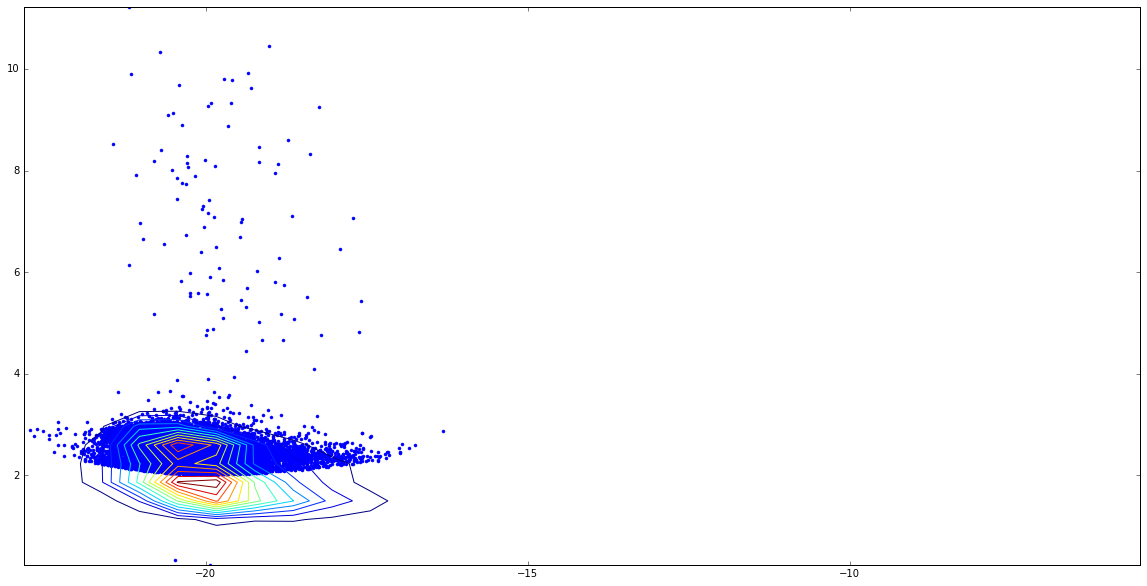

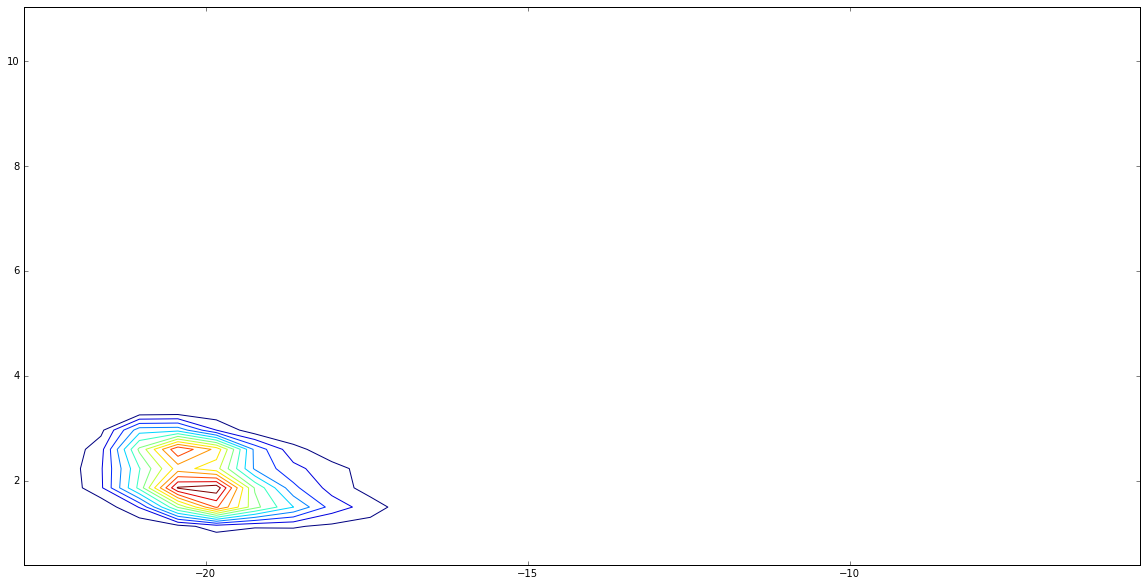

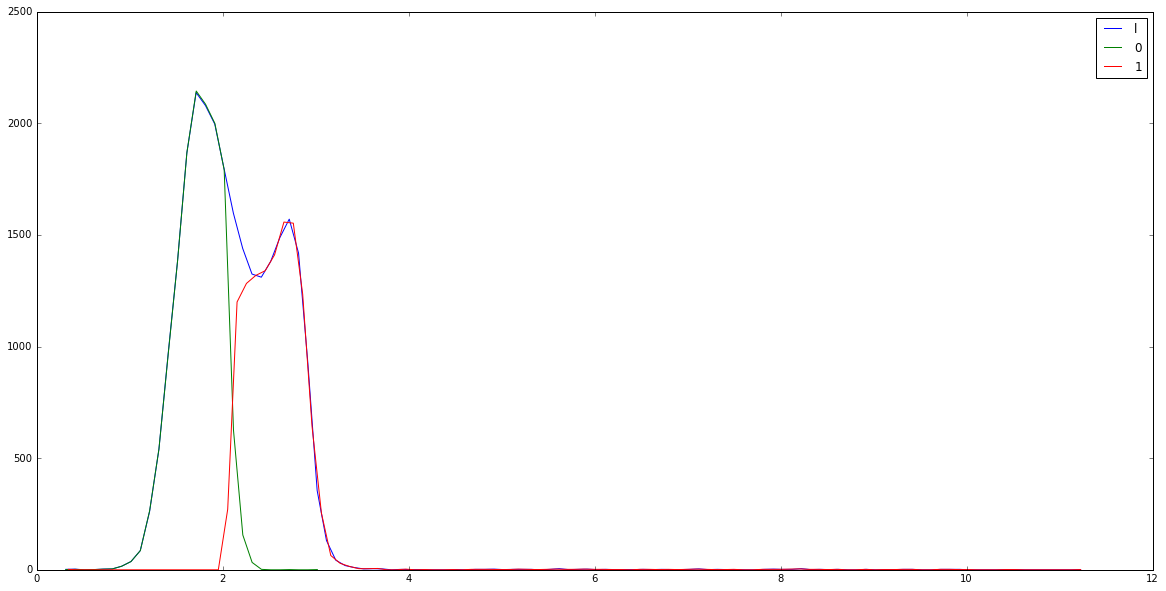

In [7]:
gmm_clustering(all_data,sall_data,3,500,'mc','full')

/home/calum/anaconda3/lib/python3.5/site-packages/matplotlib/transforms.py:1965: ComplexWarning: Casting complex values to real discards the imaginary part
  np.float_)


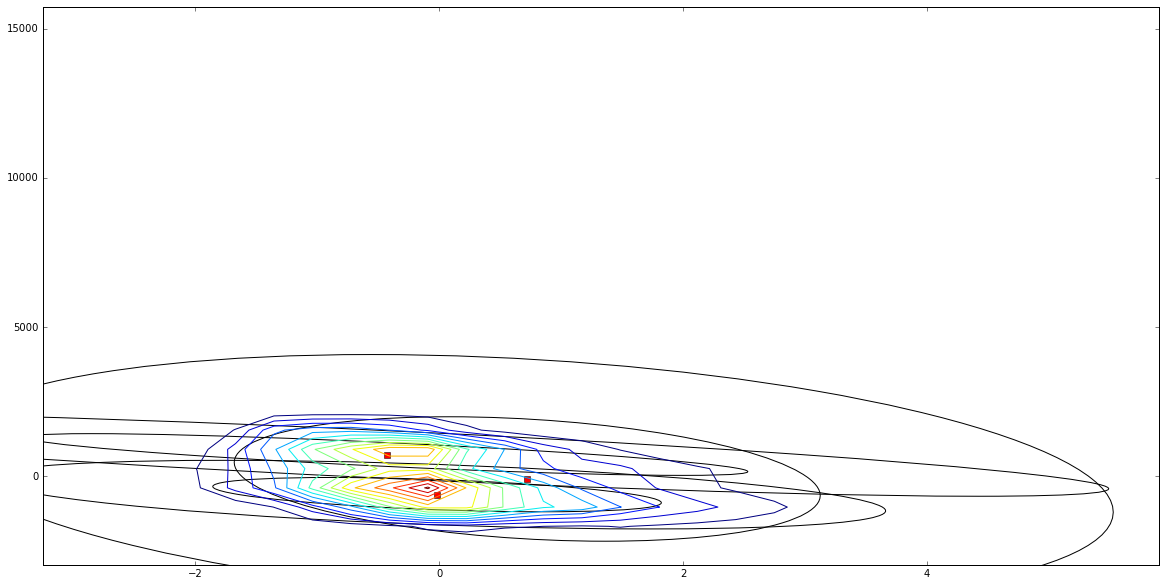

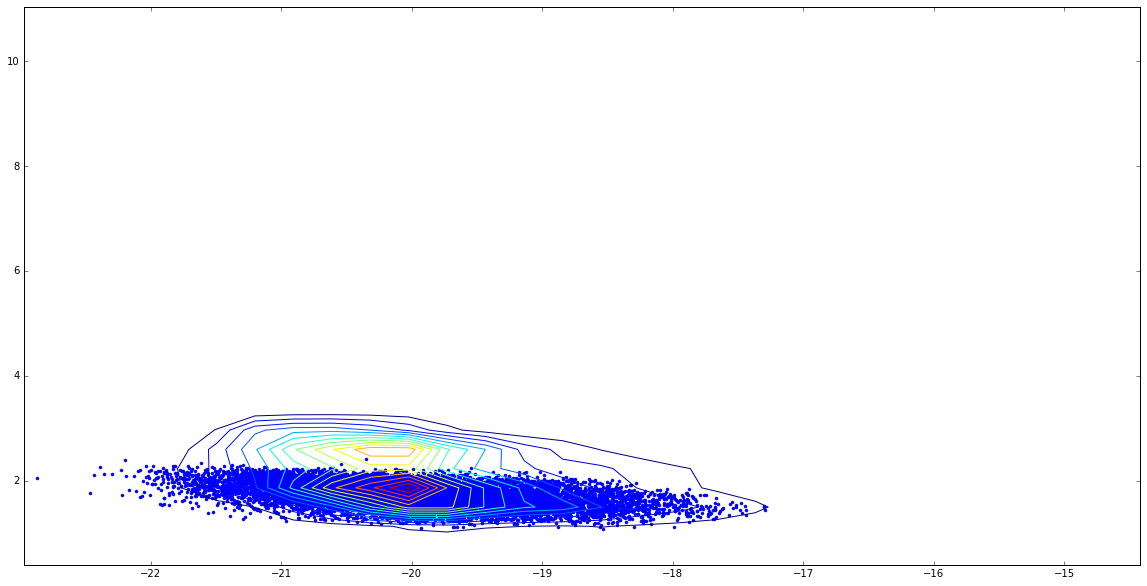

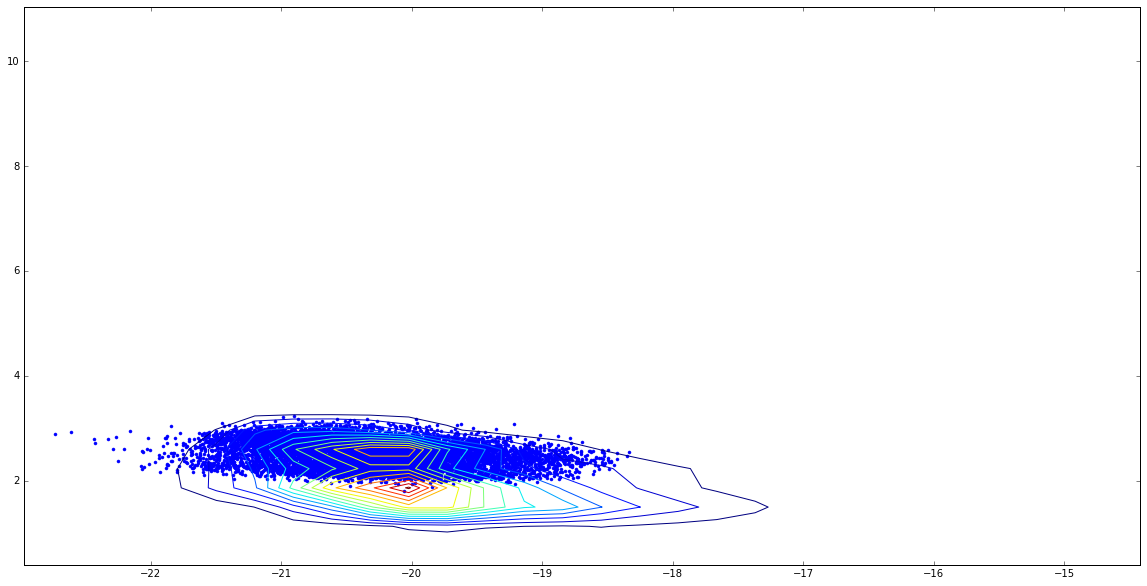

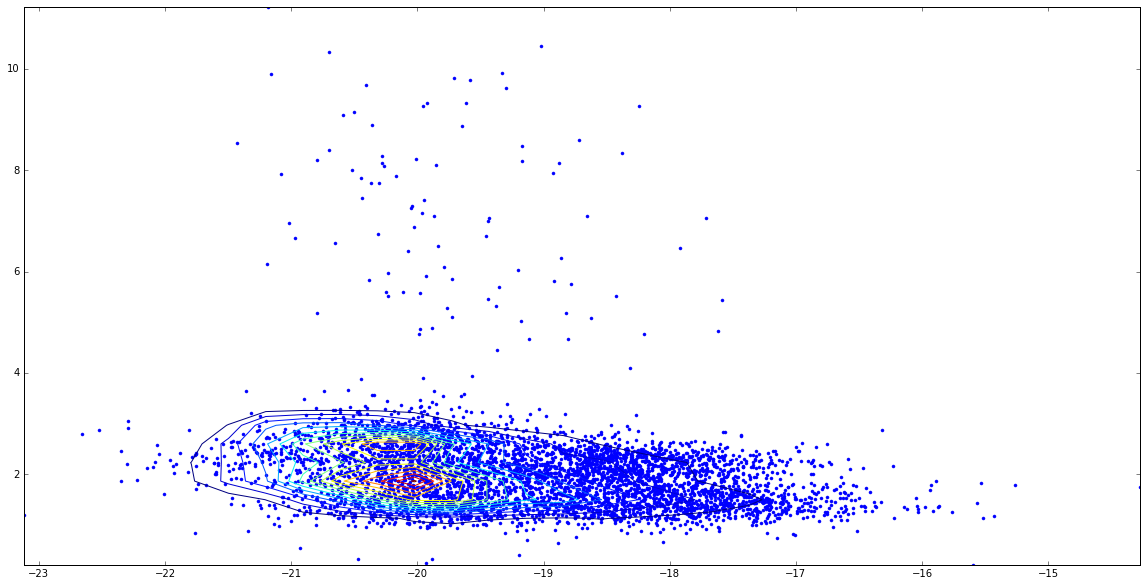

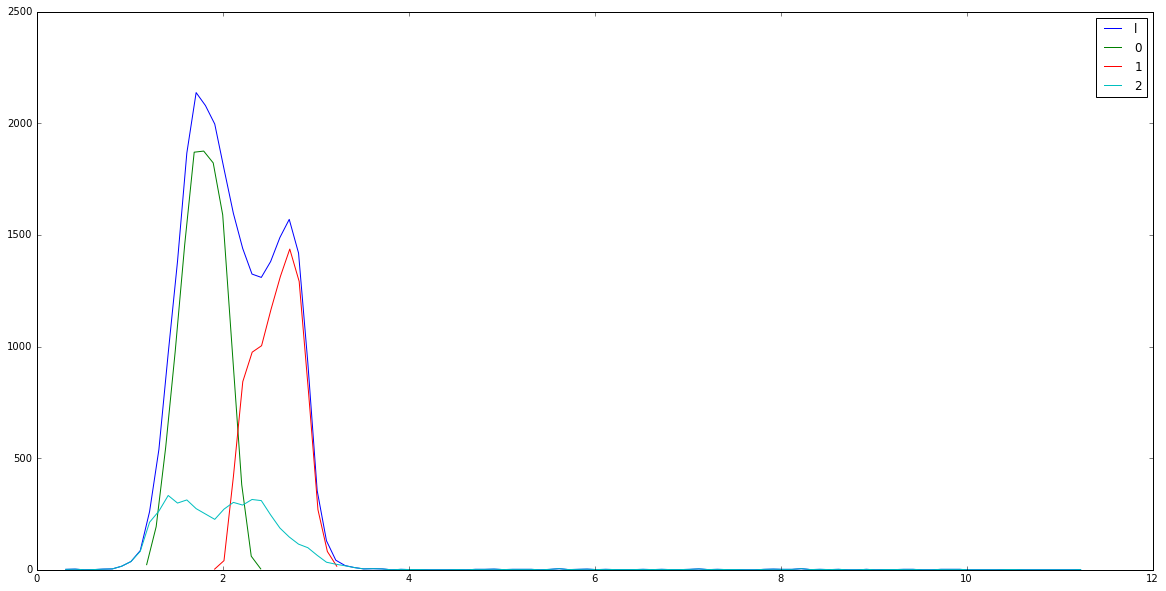

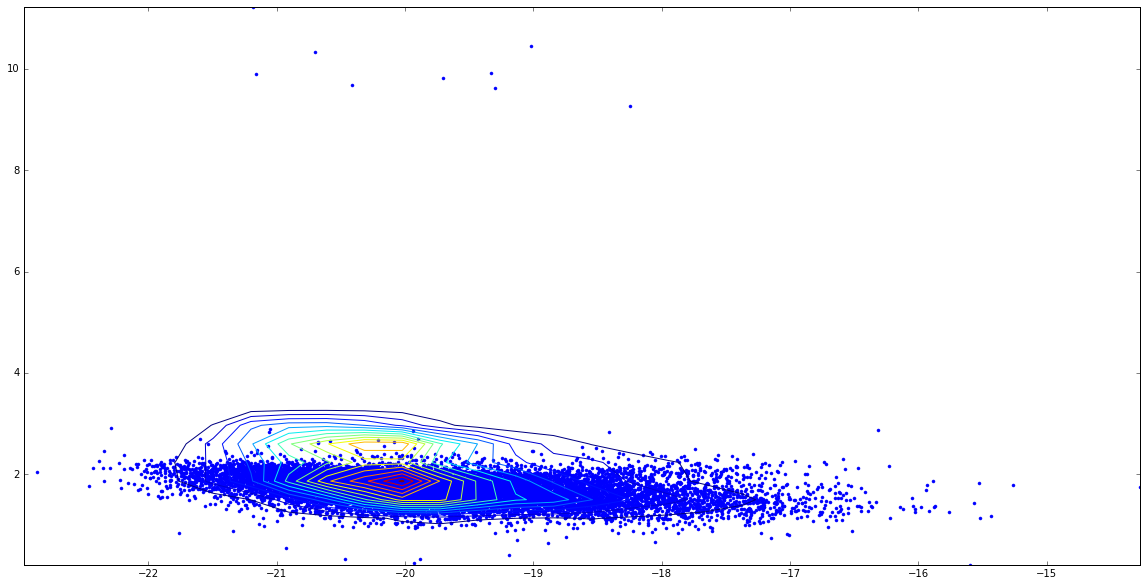

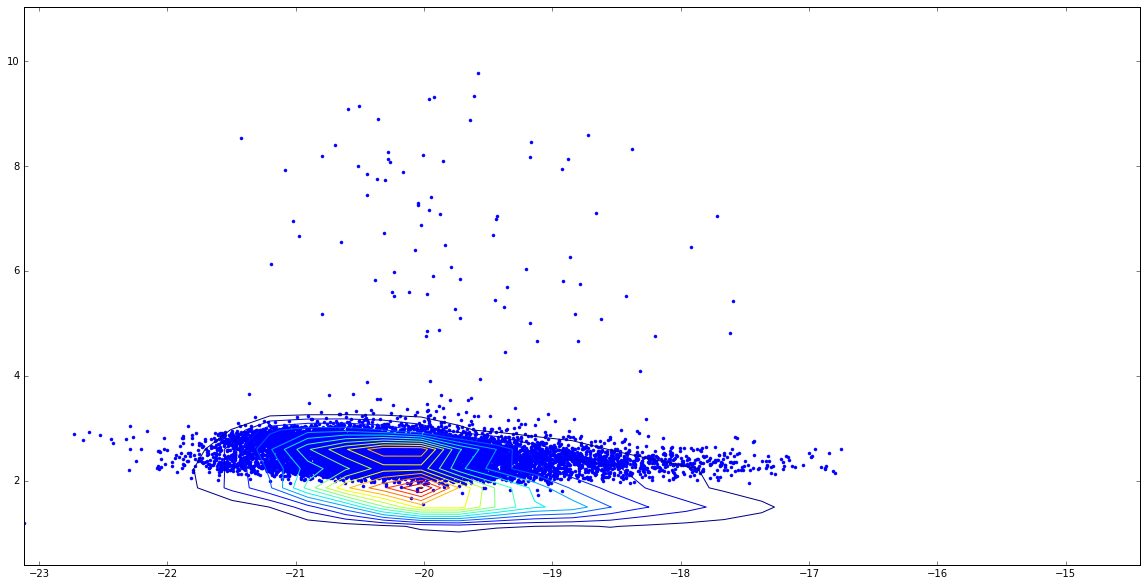

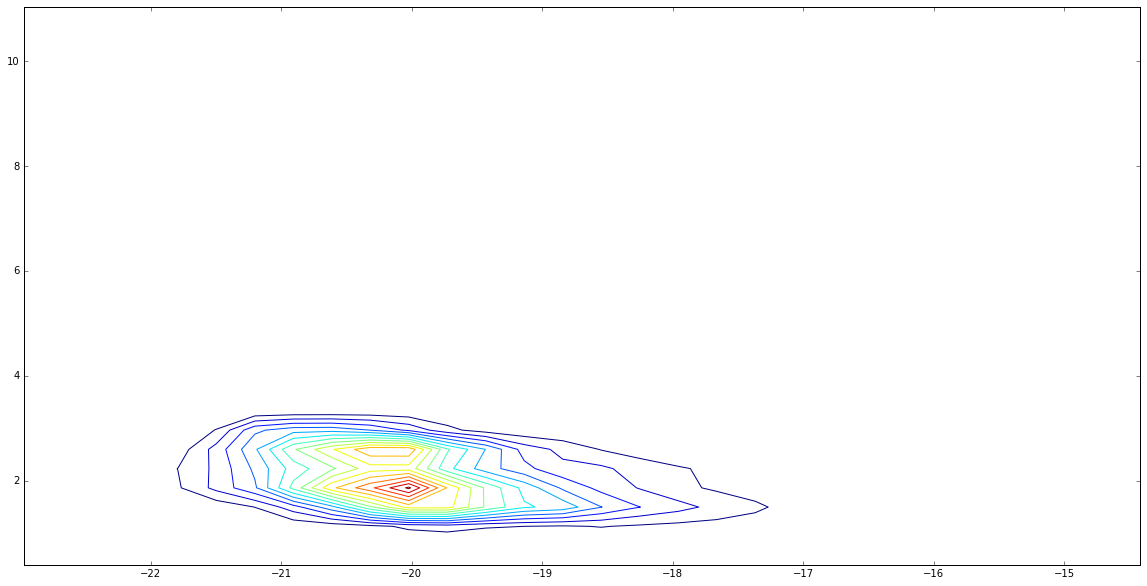

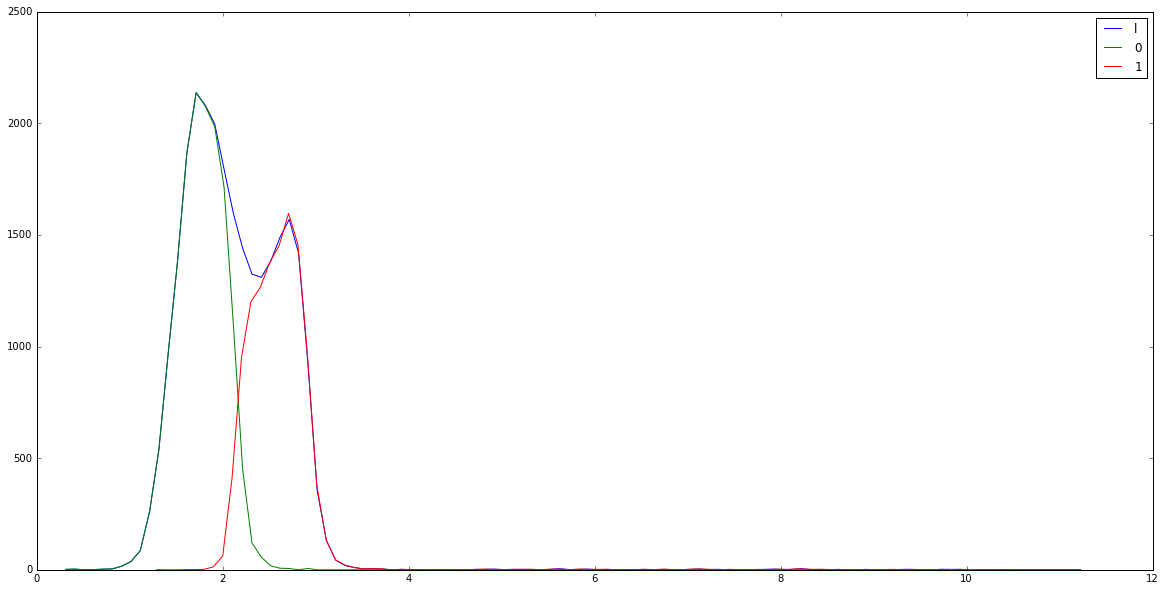

In [8]:
all_data = np.array([[row[0],row[1],row[3],row[4],row[5],row[6]] for row in data if row[2]<0.08 and row[2]>0.004])
sall_data = preprocessing.scale(all_data,axis=0)

sall_data = np.array([[row[0],row[1]*1000,row[2],row[3],row[4],row[5]] for row in sall_data])
sall_data.shape

cluster_probs = gmm_clustering(all_data,sall_data,3,500,'mc','full')

In [9]:
cluster_probs.shape

(26301, 3)

In [10]:
cluster_membership = np.argmax(cluster_probs.T[:2], axis=0)
cluster_membership.shape

(26301,)

In [11]:
x = np.array([row[0] for row in all_data])
y = np.array([row[1] for row in all_data])

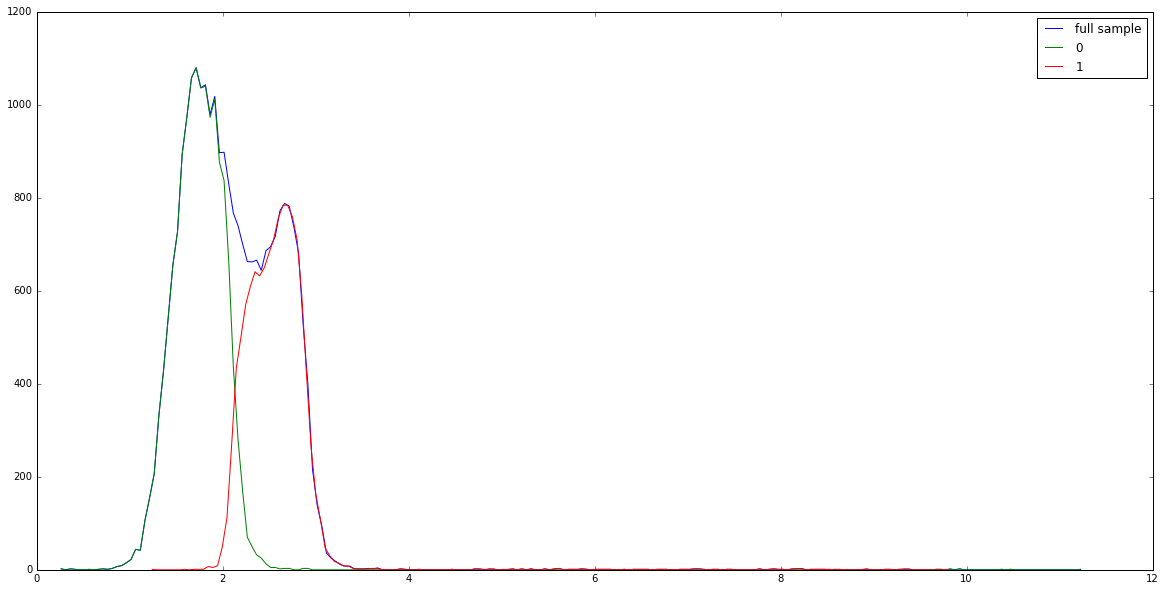

In [12]:
plt.figure(figsize=(20,10))
pt.plot_hist(y,200,'full sample',set_bin_size=True,bin_size=0.05,normed=False)

for i in range(2):
    pt.plot_hist(y[cluster_membership==i],200,str(i),set_bin_size=True,bin_size=0.05,normed=False)   
    
plt.legend()

In [13]:
full_sample = np.array([row for row in galaxies if row[5]<0.08 and row[5]>0.004])
full_sample.shape

(26301, 31)

In [24]:
blue_cloud = full_sample[cluster_membership==0]
blue_cloud.shape

(14851, 31)

In [25]:
# the different colours
names = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,'u','g','r','i','z',0,0,'Y','H','K','W1','W2','W3','W4','NUV','FUV']
indices = [15, 16, 17, 18, 19, 22, 23, 24, 25, 26, 27, 28, 29, 30]   
colour_combos = [i for i in itertools.combinations(indices,2)]
colour_combos[0]

(15, 16)

In [26]:
# histograms
for colrow in colour_combos:
    y = [row[colrow[0]]-row[colrow[1]] for row in blue_cloud if row[colrow[0]] > 0 and row[colrow[1]] > 0]  
    full_y = [row[colrow[0]]-row[colrow[1]] for row in full_sample if row[colrow[0]] > 0 and row[colrow[1]] > 0] 
    plt.figure(figsize=(40,20))
    pt.plot_hist(y,200,'blue cloud',set_bin_size=True, bin_size=0.1,normed=False)
    pt.plot_hist(full_y,200,'full sample',set_bin_size=True, bin_size=0.1,normed=False)
    plt.title('Number of galaxies in plot: '+str(len(y)))
    plt.legend()
    plt.savefig('img/comparison_cloud_histogram'+names[colrow[0]]+names[colrow[1]]+'.png')
    plt.close()

In [ ]:
# 15 sdss.u
# 16 sdss.g 
# 17 sdss.r 
# 18 sdss.i 
# 19 sdss.z
# 20 sdss.petroMag_r
# 21 sdss.petroR50_r
# 22 ukidds.yPetroMag 
# 23 ukidds.hPetroMag
# 24 ukidds.kPetroMag 
# 25 wise.w1mpro
# 26 wise.w2mpro 
# 27 wise.w3mpro
# 28 wise.w4mpro
# 29 galex.nuv_mag
# 30 galex.fuv_mag  